In [1]:
###############################################   LAB 5   ##############################################
################### Script written by Dr Alex Ter-Sarkisov@City, University of London, 2021 ############
##################### DEEP LEARNING FOR IMAGE ANALYSIS, MSC IN ARTIFICIAL INTELLIGENCE #################
########################################################################################################
import time
import torch
import torchvision
import numpy as np
import os, sys
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils import data
import torch.utils as utils
from torchvision import transforms
import dataset_icdar
from PIL import Image as PILImage
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

device = torch.device('cpu')


if torch.cuda.is_available():
   device = torch.device('cuda')

print(device)

cuda


In [60]:
def icdar_mask_rcnn_inference(im, problem, model):
    im = PILImage.open(im)
    img = np.array(im)
    t_ = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.457, 0.407],
                                         std=[1,1,1])
                     ])

    img = t_(img)
    print(img.size())
    #img = img.to(device)
    out = model([img])
    # scores + bounding boxes + labels + masks
    scores = out[0]['scores']
    bboxes = out[0]['boxes']
    classes = out[0]['labels']
    # masks: unmolded, size of the whole image
    if problem == "mask":
       mask = out[0]['masks']
       color_array = np.zeros([mask[0].shape[1], mask[0].shape[2],3], dtype=np.uint8)

    scores = scores.detach().clone().cpu().numpy()
    # for the objects with scores>threshold: 
    # add bbox and mask 
    if len(scores):
       bgr_img = np.array(PILImage.open("sign1.jpg"))
       #plt.imshow(im)       
       fig, ax = plt.subplots(1,1, figsize=(20,17))
       # plot masks
       # Do not use pytorch tensors 
       # before plotting, convert to numpy
       for id, b in enumerate(bboxes):
           #if classes[id] == 17:
           found = mask[id][0].detach().clone().cpu().numpy()
           color_array[found>0.5] = [255,0,0]
           #elif classes[id] ==18:
           #   found = mask[id][0].detach().clone().cpu().numpy()
           #   color_array[found>0.5] = [0,255,0]
           rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=1, edgecolor='red', facecolor='none')
           ax.text(b[0],b[1], id_to_chars[classes[id].item()], fontsize=14, color='blue')
           #ax.text(b[0],b[1], '{0:.2f}'.format(scores[id].item()), fontsize=15, color='green')
           ax.add_patch(rect)

       added_image = cv2.addWeighted(bgr_img, 0.5, color_array, 0.5, 0)       
       ax.imshow(added_image)
       fig.show()

In [61]:
ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

chars_list=[]
for x in ascii_letters:
    chars_list.append(x)

for i in range(10):
    chars_list.append(str(i))
chars_list.insert(0, '__bgr__')

# both dicts:chars to id and id to chars
chars_to_id = {}
id_to_chars = {}
for id, c in enumerate(chars_list):
    chars_to_id[c] = id
    id_to_chars[id] = c

print(chars_to_id)
mask_ids = chars_to_id


{'p': 16, 'o': 15, 'Z': 52, 'U': 47, 'x': 24, '4': 57, 'G': 33, '0': 53, '8': 61, 'O': 41, '9': 62, 'Y': 51, 'I': 35, 'K': 37, 'B': 28, 'M': 39, 'T': 46, 'a': 1, '2': 55, 'J': 36, 'P': 42, 'd': 4, '3': 56, 'S': 45, 'b': 2, 'X': 50, 'C': 29, 'k': 11, 'r': 18, 'H': 34, 'v': 22, 'W': 49, 'n': 14, 'c': 3, 'y': 25, 'R': 44, 'q': 17, 'w': 23, 'm': 13, '1': 54, 'i': 9, '5': 58, 'g': 7, 's': 19, 'V': 48, '__bgr__': 0, 'D': 30, 'u': 21, 'E': 31, 'Q': 43, '6': 59, '7': 60, 'f': 6, 'F': 32, 'h': 8, 'j': 10, 'e': 5, 'A': 27, 't': 20, 'l': 12, 'z': 26, 'N': 40, 'L': 38}


In [62]:
# Load ICDAR dataset
# defien the problem
problem = 'mask'
if problem == 'mask' or problem == 'char':
   gt_dir = 'icdar2015_fst/gt3'
elif problem == 'word':
   gt_dir = 'icdar2015_fst/gt1'

mask_dir = 'icdar2015_fst/gt2'
# parameters for the dataset
# if only signs are detected, gt_dir is gt1
# for characters gt_dir is gt3
# for masks gt2 and gt3
dataset_pars_sign = {'stage':'train', 'gt':os.path.join('icdar', gt_dir),'data':'icdar2015_fst/img','problem':problem,'img_max_size':[256,256], 'list_of_chars':chars_list, 'char_dict':chars_to_id, 'mask_gt': os.path.join('icdar',mask_dir)}
datapoint_sign = dataset_icdar.ICDARData(**dataset_pars_sign)
dataloader_pars_sign = {'shuffle':True, 'batch_size':1}
dataloader_pars = data.DataLoader(datapoint_sign, **dataloader_pars_sign)

In [68]:
######################################################
if problem == 'char' or problem == 'mask':
   maskrcnn_args = {'num_classes':len(chars_list), 'pretrained':False, 'box_score_thresh':0.5, 'box_nms_thresh':0.25}
elif problem == 'word':
   maskrcnn_args = {'num_classes':2, 'pretrained':False}
####################### EVAL OF THE PRETRAINED MODEL (ONLY MASK!) #############################
pretrained_weights = torch.load("icdar2015_fst/maskrcnn_model_icdar2015_fst_masks.pth")
mask_rcnn_icdar = torchvision.models.detection.maskrcnn_resnet50_fpn(**maskrcnn_args)
mask_rcnn_icdar.load_state_dict(pretrained_weights)
mask_rcnn_icdar.eval()
print(mask_rcnn_icdar)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

torch.Size([3, 662, 800])


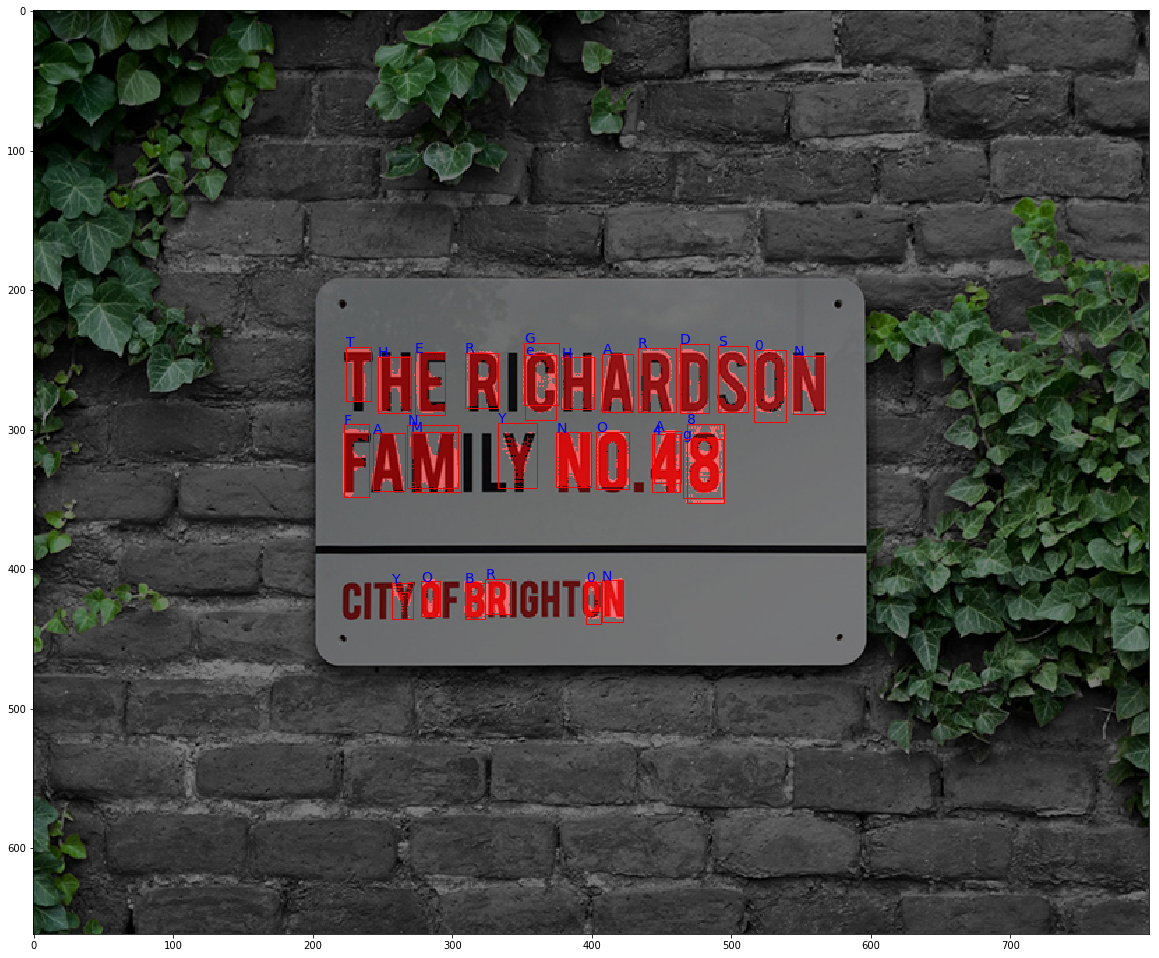

In [69]:
icdar_mask_rcnn_inference(im="sign1.jpg", problem="mask", model=mask_rcnn_icdar)

In [70]:
# Modeling exercise: write ICDAR2015-FST training script, evaluate using gt masks/boxes. 